In [8]:
# Importiere den Datensatz von kaggle: https://www.kaggle.com/datasets/abcsds/pokemon
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abcsds/pokemon")

print("Path to dataset files:", path)
# Datei heißt pokemon.csv

Path to dataset files: /root/.cache/kagglehub/datasets/abcsds/pokemon/versions/2


In [15]:
import pandas as pd

pokemon = pd.read_csv(path + '/Pokemon.csv')

# Datenexploration
print(pokemon.head()) # Ersten 5 Datensätze ansehen
print(pokemon.info()) # Spalten, Werte und Datentypen
print(pokemon.isnull().sum()) # Es gibt einige Null Werte bei Type2

   #                   Name Type 1  Type 2  Total  HP  Attack  Defense  \
0  1              Bulbasaur  Grass  Poison    318  45      49       49   
1  2                Ivysaur  Grass  Poison    405  60      62       63   
2  3               Venusaur  Grass  Poison    525  80      82       83   
3  3  VenusaurMega Venusaur  Grass  Poison    625  80     100      123   
4  4             Charmander   Fire     NaN    309  39      52       43   

   Sp. Atk  Sp. Def  Speed  Generation  Legendary  
0       65       65     45           1      False  
1       80       80     60           1      False  
2      100      100     80           1      False  
3      122      120     80           1      False  
4       60       50     65           1      False  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        8

In [16]:
# Datenvorbereitung
# Entferne unwichtige Spalten
pokemon_clean = pokemon.drop(['#', 'Name', 'Total'], axis=1)

# Behandle fehlende Werte in 'Type 2'
pokemon_clean['Type 2'] = pokemon['Type 2'].fillna('None')

# Feature Engineering
# One-Hot Encoding für kategorische Variablen
pokemon_final = pd.get_dummies(pokemon_clean, columns=['Type 1', 'Type 2', 'Generation'])

# Aufteilung in Features und Target
# X sind die Features -> Wir entfernen das Label
X = pokemon_final.drop('Legendary', axis=1)
# Y ist das Label
y = pokemon_final['Legendary']

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelltraining
rf = RandomForestClassifier(
    n_estimators = 100,
    random_state = 42,
    class_weight='balanced'  # Hilft bei unausgeglichenen Klassen
)

rf.fit(X_train, y_train)

# Vorhersagen und Evaluation
y_pred = rf.predict(X_test)

print("\nModel Performance:")
print(f"Genauigkeit: {accuracy_score(y_test, y_pred):.2f}")
print("\nKlassifikationsbericht:")
print(classification_report(y_test, y_pred))
print("\nKonfusionsmatrix:")
print(confusion_matrix(y_test, y_pred))

# 9. Feature Importance Analyse
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nWichtigste Features:")
print(feature_importances.head(10))


Model Performance:
Genauigkeit: 0.96

Klassifikationsbericht:
              precision    recall  f1-score   support

       False       0.97      0.99      0.98       150
        True       0.75      0.60      0.67        10

    accuracy                           0.96       160
   macro avg       0.86      0.79      0.82       160
weighted avg       0.96      0.96      0.96       160


Konfusionsmatrix:
[[148   2]
 [  4   6]]

Wichtigste Features:
           feature  importance
3          Sp. Atk    0.170184
5            Speed    0.155556
4          Sp. Def    0.141242
1           Attack    0.129317
0               HP    0.124704
2          Defense    0.108742
20  Type 1_Psychic    0.020261
44    Generation_3    0.010721
42    Generation_1    0.010069
8    Type 1_Dragon    0.009994


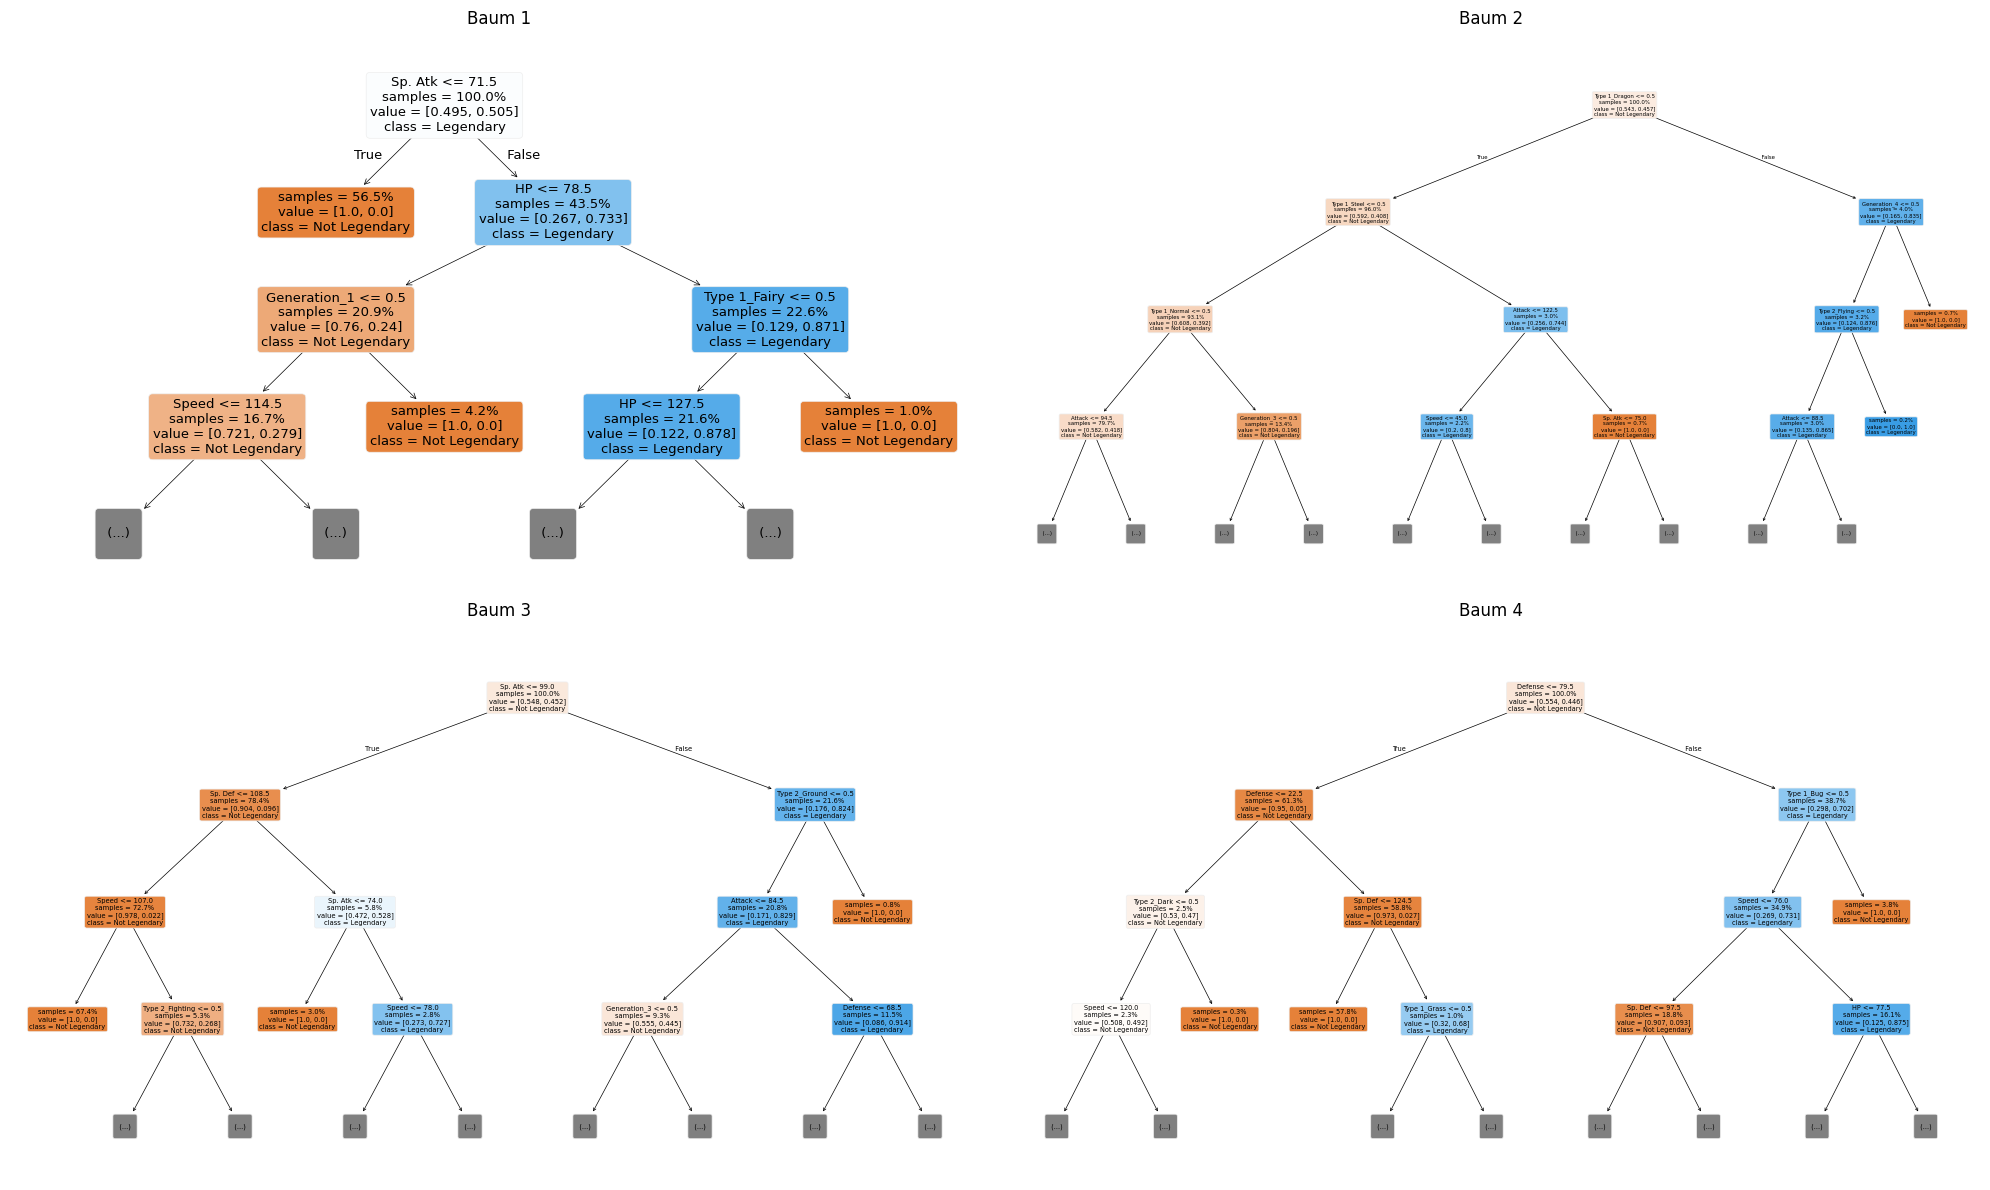

In [29]:
# 8. Visualisierung der ersten 4 Bäume
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Setze Stil für bessere Darstellung
plt.style.use('ggplot')

# Erstelle Subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
axes = axes.flatten()

# Feature-Namen für die Beschriftung
feature_names = X.columns.tolist()
class_names = ['Not Legendary', 'Legendary']

# Plot der ersten 4 Bäume
for i in range(4):
    plot_tree(rf.estimators_[i],
              feature_names=feature_names,
              class_names=class_names,
              filled=True,
              ax=axes[i],
              proportion=True,
              rounded=True,
              impurity=False,
              max_depth=3)  # Begrenze die Tiefe für bessere Lesbarkeit
    axes[i].set_title(f'Baum {i+1}', fontsize=12, pad=20)

plt.tight_layout()
plt.show()

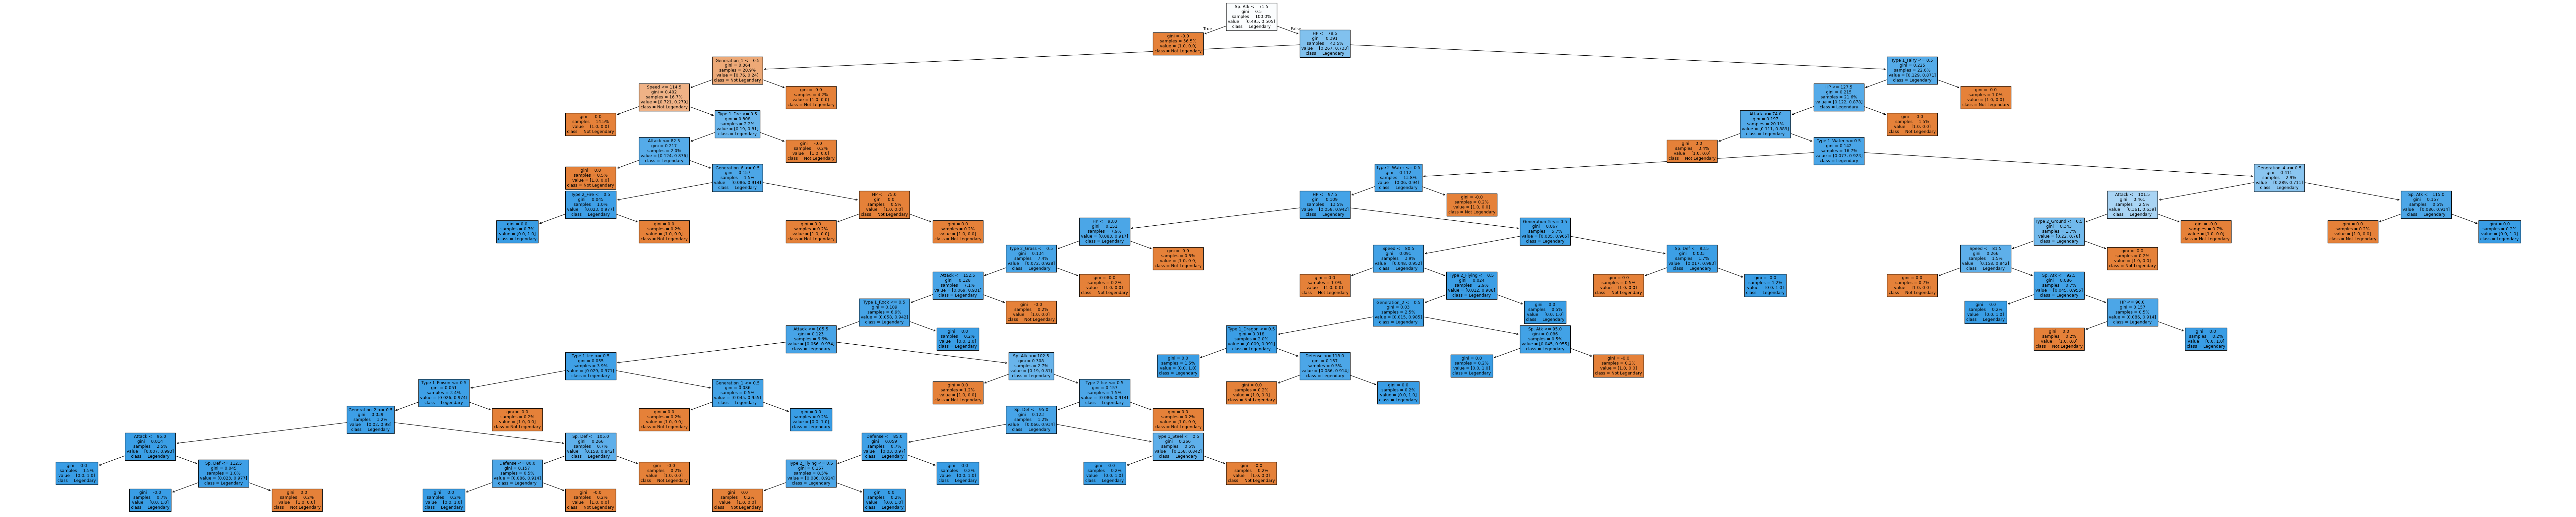

In [20]:
# Für komplette Bäume (Achtung: Sehr groß!)
plt.figure(figsize=(100, 20))
plot_tree(rf.estimators_[0],
          feature_names=feature_names,
          class_names=class_names,
          filled=True,
          proportion=True)
plt.show()

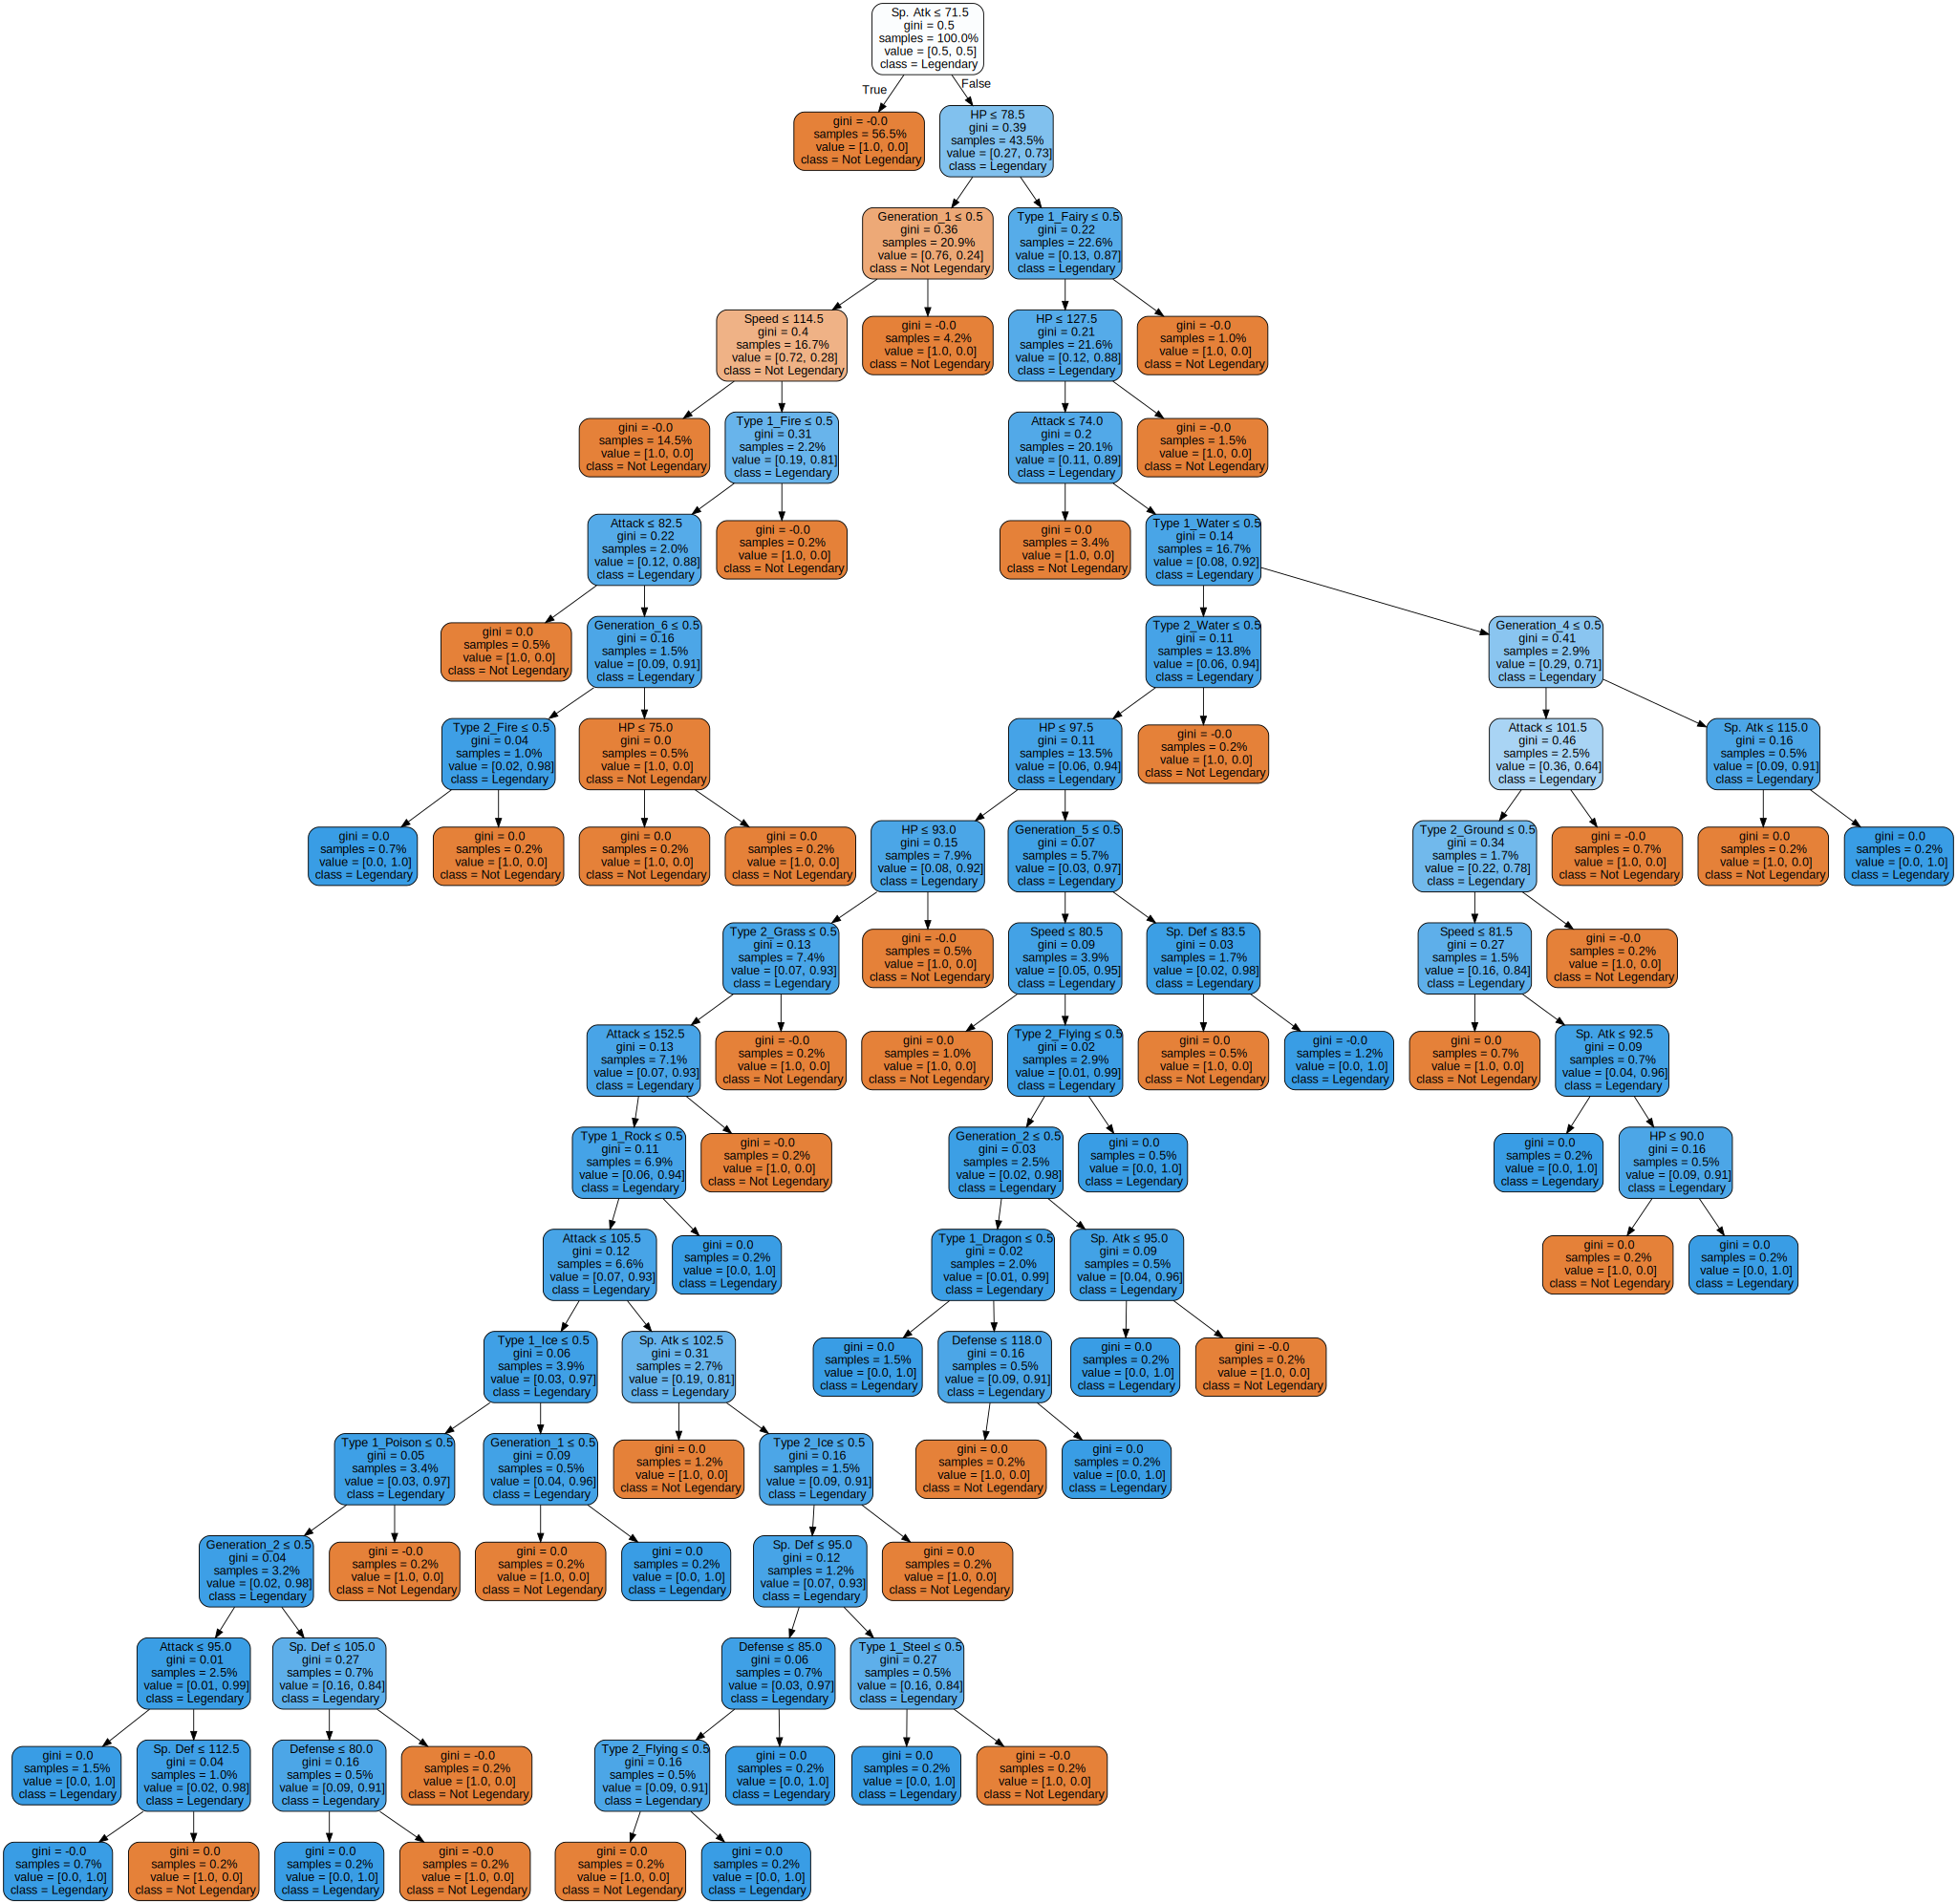

In [30]:
    dot_data = export_graphviz(rf.estimators_[0],
                               feature_names=feature_names,
                               class_names=class_names,
                               filled=True,
                               rounded=True,
                               special_characters=True,
                               proportion=True,
                               precision=2)
    graph = graphviz.Source(dot_data)
    display(graph)  # In Jupyter Notebook
